### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

metodi:
 - di partizionamento -> k-means
 - gerarchici -> BIRCH, ROCK, Chameleon
 - basati sulla densità -> DBScan
 - basati sulla griglia -> STING, Wavecluster, CLIQUE
 - basati sul modello -> Expectation Maximization, CobWeb

### Import dataset

In [2]:
# Read the data from the CSV file
#train_data = pd.read_csv('dataset/train.csv')
train_data = pd.read_csv('dataset/preproccessed_train.csv')

seed = 7
#Mapping classi to genere
genres = ['Acoustic/Folk', 'Alt Music', 'Blues', 'Bollywood', 'Country', 'HipHop', 'Indie', 'Instrumental', 'Metal', 'Pop', 'Rock']
numeric_features = [item for item in train_data.columns.to_list() if item not in ['Class', 'Genre','Artist_Name', 'Track_Name']]

### Undersampling

In [3]:
#Do undersampling of the classes keeping one thousand values for classes with more than one thousand values and for the classes that have less than one thousand values, keep them as they are. Then split data into train e test
n_sample = 367

# Calculate the value counts of each class
class_counts = train_data['Class'].value_counts()

# Identify the classes with more than one thousand values
classes_to_undersample = class_counts[class_counts > n_sample].index

# Create an empty DataFrame to store the undersampled data
undersampled_data = pd.DataFrame()

# Undersample the classes with more than one thousand values
for class_label in classes_to_undersample:
    class_data = train_data[train_data['Class'] == class_label].sample(n_sample, replace=True)
    undersampled_data = pd.concat([undersampled_data, class_data])

# Keep the classes with less than one thousand values as they are
classes_to_keep = class_counts[class_counts <= n_sample].index
for class_label in classes_to_keep:
    class_data = train_data[train_data['Class'] == class_label]
    undersampled_data = pd.concat([undersampled_data, class_data])

# Split the undersampled data into train and test
X = undersampled_data[numeric_features]
y = undersampled_data['Class']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(undersampled_data['Class'].value_counts())

10    367
6     367
9     367
8     367
5     367
1     367
2     367
0     367
7     367
3     367
4     367
Name: Class, dtype: int64


### Normalize data

In [13]:
#Do normalization of the data
scaler = StandardScaler()
scaler.fit(train_data[numeric_features])
scaled_features = scaler.transform(train_data[numeric_features])
scaled_features_df = pd.DataFrame(scaled_features, index=train_data.index, columns=numeric_features)


AttributeError: 'numpy.ndarray' object has no attribute 'index'

### Find the number of principal components

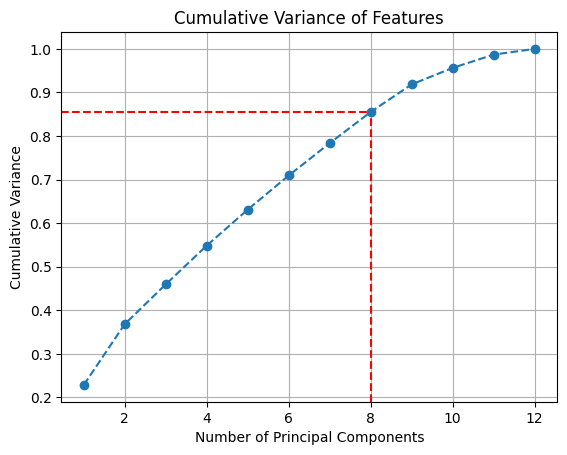

In [6]:
# Calculate the cumulative explained variance ratio
pca = PCA(n_components=12)
pca.fit(scaled_features_df[numeric_features])
train_data_pca = pca.transform(scaled_features_df[numeric_features])
train_data_pca = pd.DataFrame(train_data_pca, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12'])
train_data_pca['Class'] = train_data['Class']

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance with dotted line and dots
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance of Features')

# Add grid
plt.grid(True)

# Add a dotted line
plt.axvline(x=8, linestyle='--',ymax=0.77 ,color='red')
plt.axhline(y=0.855, linestyle='--',xmax=0.62 ,color='red')

plt.show()



### PCA

In [12]:
#Do pca to reduce the number of features
x = scaled_features_df[numeric_features]
pca = PCA(n_components=3)
pca_components = ['pca1', 'pca2', 'pca3']
pca.fit(X)
#pca.fit(x)
train_data_pca = pca.transform(X)
train_data_pca = pd.DataFrame(train_data_pca, columns=pca_components)
train_data_pca['Class'] = y.values
#train_data_pca['Class'] = scaled_features_df['Class']

c:\Users\Luca\miniconda3\envs\tmp\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


ValueError: Length of values (4037) does not match length of index (17568)

In [49]:
len(train_data_pca)

4037

### Elbow Method

In [ ]:
# Applica metodo di elbow per trovare il numero di cluster

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=seed)
    kmeans.fit(train_data_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss,'o--')
plt.title('Metodo di Elbow')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.show()


## K-Means

In [10]:
#Do kmeans clustering

kmeans = KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=seed)
#plot the clusters
kmeans.fit(train_data_pca[pca_components])
train_data_pca['Cluster'] = kmeans.labels_

#evaaluate the clusters
silhouette_avg = silhouette_score(train_data_pca[pca_components], kmeans.labels_)
print("For n_clusters =", 11,
      "The average silhouette_score is :", silhouette_avg)

For n_clusters = 11 The average silhouette_score is : 0.7027842638617064


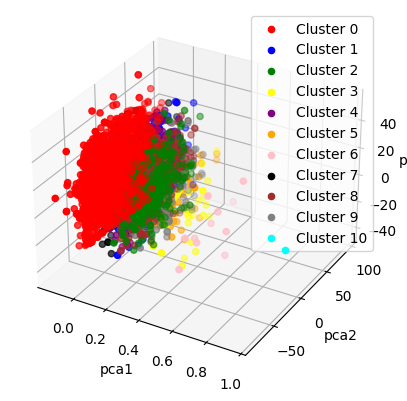

In [11]:
#Make a 3d scatter plot of the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'black', 'brown', 'grey', 'cyan']
for i in range(11):
    ax.scatter(train_data_pca[train_data_pca['Cluster'] == i]['pca1'], train_data_pca[train_data_pca['Cluster'] == i]['pca2'], train_data_pca[train_data_pca['Cluster'] == i]['pca3'], c=colors[i], label='Cluster ' + str(i))
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.legend()
plt.show()


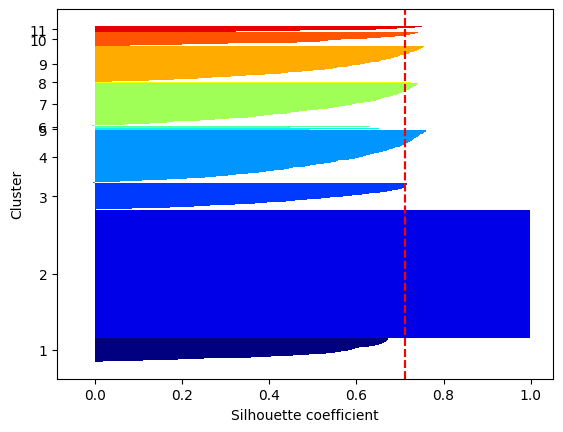

In [52]:
#make a silhoutte plot of the clusters
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

X = train_data_pca[pca_components]
y = train_data_pca['Cluster']
cluster_labels = np.unique(y)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.axvline(silhouette_avg, color="red", linestyle="--", label="Average Silhouette")
plt.show()


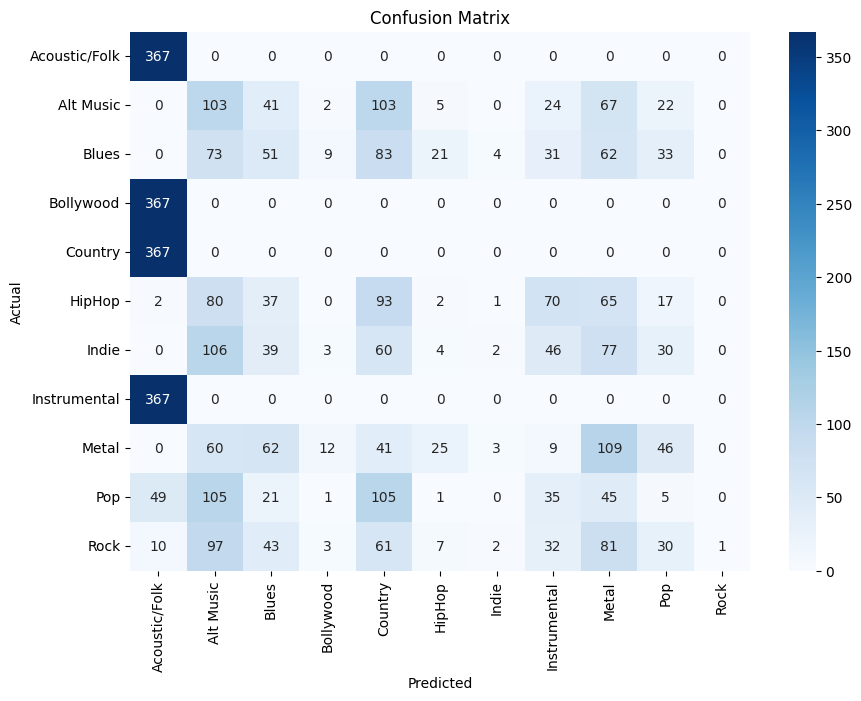

In [12]:
#do a confusion matrix of the clusters and the classes
conf_matrix = confusion_matrix(train_data_pca['Class'], train_data_pca['Cluster'])
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')   
plt.show()

### DBScan

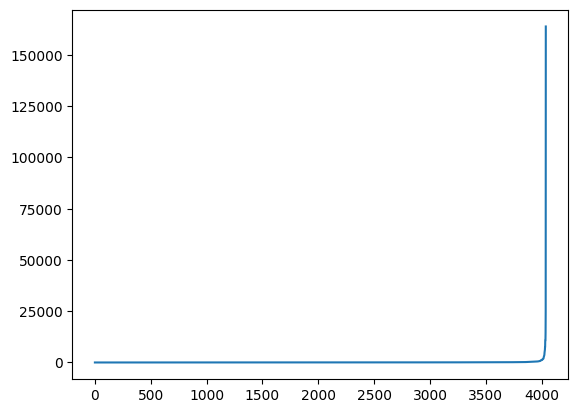

In [53]:
# do a k-dist method to find the best eps for dbscan
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train_data_pca[pca_components])
distances, indices = nbrs.kneighbors(train_data_pca[pca_components])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()


In [54]:

# Create an instance of DBSCAN
dbscan = DBSCAN()

# Fit the data to the DBSCAN model
dbscan.fit(X)

# Get the cluster labels
cluster_labels = dbscan.labels_

# Evaluate the clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)


The average silhouette_score is : -0.12078279294317971


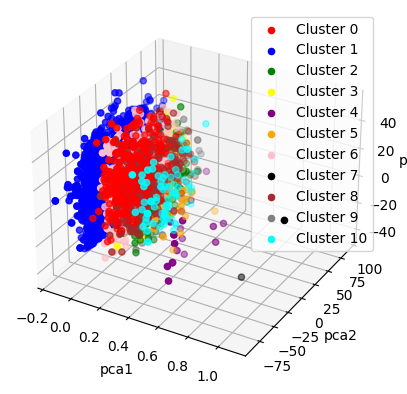

In [55]:
#Make a 3d scatter plot of the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'black', 'brown', 'grey', 'cyan']
for i in range(11):
    ax.scatter(train_data_pca[train_data_pca['Cluster'] == i]['pca1'], train_data_pca[train_data_pca['Cluster'] == i]['pca2'], train_data_pca[train_data_pca['Cluster'] == i]['pca3'], c=colors[i], label='Cluster ' + str(i))
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.legend()
plt.show()
